<h1>Importing Libraries</h1>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from torchvision import models
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.neighbors import KNeighborsClassifier

sns.set_theme(style="darkgrid", font_scale=1.5, rc={"axes.unicode_minus":False})

<h1>Read Dataset</h1>

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Testing data transformations
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root="C:\\Users\\HB Laptop Store\\Desktop\\AI-Practical-Tasks\\2023-2024\\final\\Group E - Vehicle Classification\\long_dataset\\train", transform=train_transform)
val_dataset = datasets.ImageFolder(root="C:\\Users\\HB Laptop Store\\Desktop\\AI-Practical-Tasks\\2023-2024\\final\\Group E - Vehicle Classification\\long_dataset\\val", transform=test_transform)

# the number of samples that will be processed in each iteration during training.
batch_size = 64
# create iterators for the training, validation, and testing datasets.
# 2000 images / 64 batch_size = 32 iterations
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

<h1>Visualization</h1>

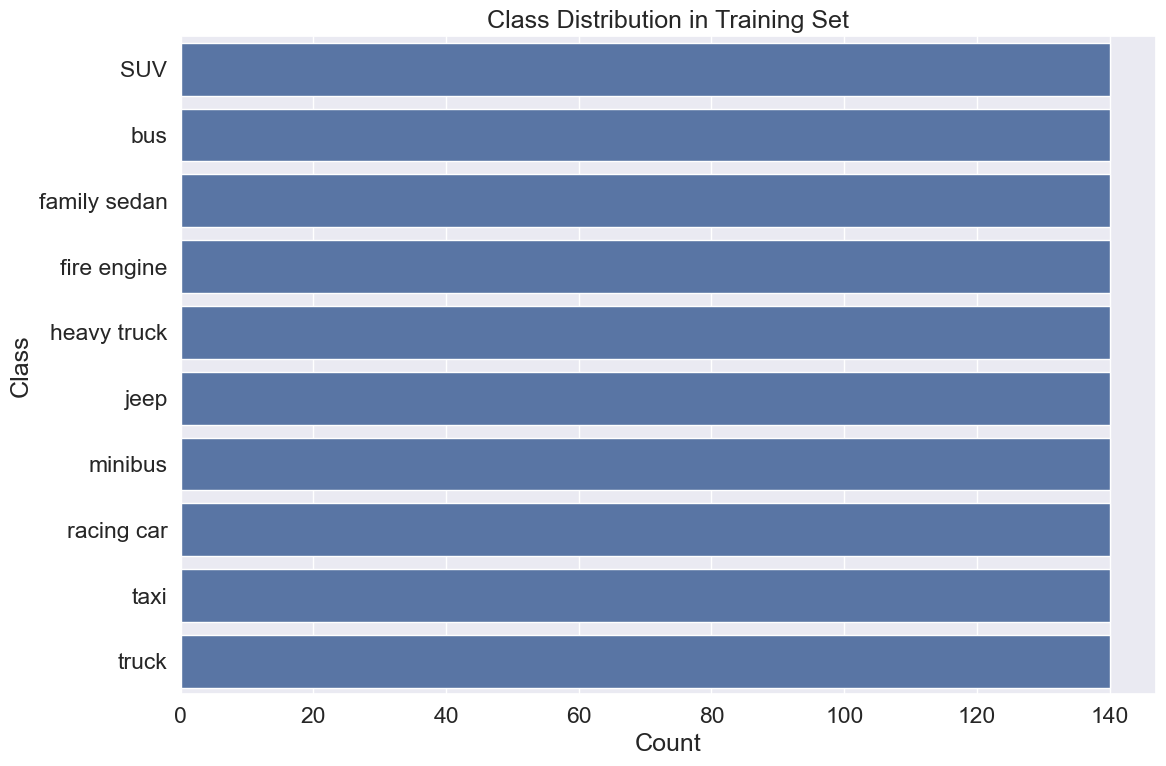

In [3]:
class_names = train_dataset.classes
class_count = [train_dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count})

plt.figure(figsize=(12, 8), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.title("Class Distribution in Training Set")
plt.tight_layout()
plt.show()

<h1>Feature Extraction</h1>

In [4]:
def extract_features(image, model):
    with torch.no_grad():
        features = model(image)
    return features.squeeze().numpy()

# Extract features for each image in the dataset
def extract_dataset_features(loader, model):
    features, labels = [], []
    for images, labels_batch in loader:
        # The extracted features for the entire batch are stored in the batch_features list
        batch_features = [extract_features(image.unsqueeze(0), model) for image in images]
        features.extend(batch_features)
        labels.extend(labels_batch.numpy())
    return np.array(features), np.array(labels)

In [ ]:
# Feature extraction using ResNet18
resnet50 = models.resnet50(pretrained=True)
resnet50 = nn.Sequential(*list(resnet50.children())[:-1])

train_features, train_labels = extract_dataset_features(train_loader, resnet50)
val_features, val_labels = extract_dataset_features(val_loader, resnet50)

In [ ]:
def save_to_csv(features, labels, filename):
    features_df = pd.DataFrame(features)
    labels_df = pd.DataFrame(labels, columns=["Class"])
    data_df = pd.concat([labels_df, features_df], axis=1)
    os.makedirs('features', exist_ok=True)
    file_path = os.path.join('features', filename)
    data_df.to_csv(file_path, index=False)

# Save extracted features
save_to_csv(train_features, train_labels, "temp-train.csv")
save_to_csv(val_features, val_labels, "temp-test.csv")

In [5]:
def load_from_csv(file_path):
    data_df = pd.read_csv(file_path)
    labels = data_df["Class"].values
    features = data_df.drop("Class", axis=1).values
    features_tensor = torch.tensor(features, dtype=torch.float32)
    return features_tensor, labels

# Load features
train_features, train_labels = load_from_csv('./features/svm-train.csv')
val_features, val_labels = load_from_csv('./features/svm-test.csv')

<h1>Training</h1>

In [6]:
knn_model = KNeighborsClassifier(n_neighbors=13)  # Adjust the metric
knn_model.fit(train_features, train_labels)

Validation Accuracy: 0.805


<h1>Predict Test Data</h1>

In [ ]:
val_predictions = knn_model.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.3f}")

<h1>Loss & Accuracy</h1>

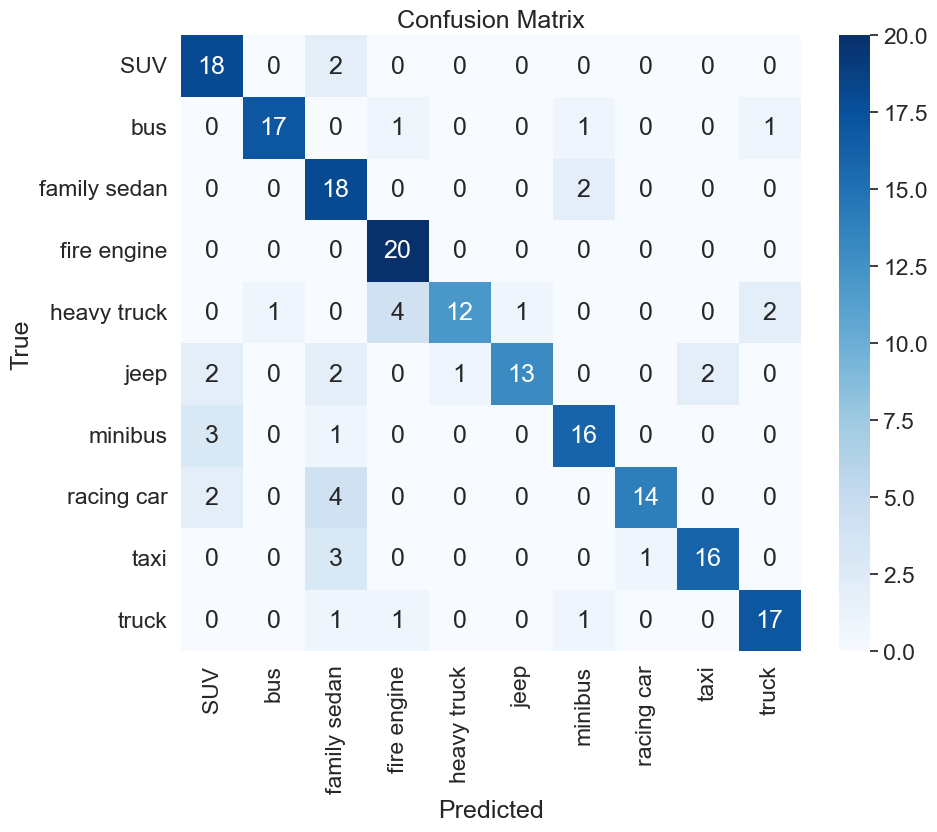

In [7]:
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()